In [8]:
%load_ext autoreload
%autoreload 2
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

import numpy as np

import os
import matplotlib.pyplot as plt


from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.Analysis.utils import filter_opto_data, violin_scatter
from ms_stim_analysis.Style.style_guide import animal_style, interval_style
from ms_stim_analysis.AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance, BadDecodes
from ms_stim_analysis.AnalysisTables.place_fields import DecodesToCoveredTrack

from ms_stim_analysis.AnalysisTables.decoding_tables import RippleClusterlessDecodeAnalysisSelection, RippleClusterlessDecodeAnalysis

def get_speed_v2(posterior, distance_dict, place_bin_center_ind_to_node, dt):
    speed = np.zeros(posterior.shape[0])
    for i in range(posterior.shape[0]):
        pos = place_bin_center_ind_to_node[np.argmax(posterior[i])]
        if i == 0:
            continue
        prev_pos = place_bin_center_ind_to_node[np.argmax(posterior[i - 1])]
        speed[i] = distance_dict[prev_pos][pos] / dt
    return speed


/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2025-09-09 09:09:20,422][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [9]:
from ms_stim_analysis.Style.style_guide import animal_style
from tqdm import tqdm

track_coverage_filter = False
artifact_detection = "ms_lfp_artifact_times"
min_continuous_duration = 50  # milliseconds

animal_list = animal_style.index


results = {}
for animal in animal_list:
    data_list = (
        RippleClusterlessDecodeAnalysis()
        & "nwb_file_name LIKE '%{}%'".format(animal)
        & f"target_interval_list_name LIKE '%{artifact_detection}'"
    )
    data_list = data_list - (BadDecodes() & {"bad_decodes": 1})
    # data_list = data_list & DecodesToCoveredTrack().proj()
    ripple_speeds = []
    for key in tqdm(data_list.fetch("KEY")[:], desc=f"Processing {animal}"):
        data = data_list & key
        df = data.fetch_dataframe()

        # valid_intervals = (DecodesToCoveredTrack() & data.proj()).fetch_intervals()
        ripple_classification = data.classify_ripple_decode(
            locality_threshold=20,
            valid_intervals=None,  # valid_intervals,
            valid_interval_fraction=0.8,
            thresh_percent=0.8,
        )
        df = df.iloc[ripple_classification == "Continuous"]

        clusterless_key = (ClusterlessDecodingV1() & data).fetch1("KEY")
        decoding_results = (ClusterlessDecodingV1() & data).fetch_results()
        environment = ClusterlessDecodingV1().fetch_environments(clusterless_key)[0]
        distance_dict = environment.distance_between_nodes_
        nodes_df = environment.nodes_df_
        # nodes_df = nodes_df.i
        place_bin_center_ind_to_node = []
        for pos in decoding_results.state_bins.position.values:
            ind = np.argmin(np.abs(nodes_df.linear_position - pos))
            place_bin_center_ind_to_node.append(nodes_df.iloc[ind].node_id)
        place_bin_center_ind_to_node = np.array(place_bin_center_ind_to_node)

        for row in df.itertuples():
            # raise NotImplementedError("This code is not yet implemented for continuous traversals.")
            speed = get_speed_v2(
                row.pos_posterior, distance_dict, place_bin_center_ind_to_node, 0.002
            )
            valid_inds = (row.state_posterior[:, 0] >= 0.8).astype(int)
            change_valid = np.diff(valid_inds)
            starts = np.where(change_valid == 1)[0] + 1
            ends = np.where(change_valid == -1)[0] + 1
            if valid_inds[0] == 1:
                starts = np.insert(starts, 0, 0)
            if valid_inds[-1] == 1:
                ends = np.append(ends, len(valid_inds) - 1)
            valid_intervals = np.array([starts, ends]).T
            valid_durations = valid_intervals[:, 1] - valid_intervals[:, 0]
            valid_intervals = valid_intervals[
                valid_durations >= (min_continuous_duration / 2)
            ]
            if not valid_intervals.size:
                continue

            frag_inds = np.where(row.state_posterior[:, 0] < 0.8)[0]
            for pad_i in np.arange(-3, 3):
                speed[frag_inds] = np.nan
                pad_frag_inds = np.clip(frag_inds + pad_i, 0, len(speed) - 1)
                speed[pad_frag_inds] = np.nan

            calc_speed = np.concatenate([speed[s:e] for s, e in valid_intervals])

            ripple_speeds.append(np.nanmean(calc_speed))

    if ripple_speeds:
        results[animal] = ripple_speeds
    # print(ripple_speed)
# speed[~cont_inds] = np.nan

Processing Totoro: 100%|██████████| 6/6 [02:27<00:00, 24.63s/it]
Processing Banner: 0it [00:00, ?it/s]
Processing Odins: 0it [00:00, ?it/s]
Processing Bilbo: 100%|██████████| 6/6 [04:30<00:00, 45.05s/it]
Processing transfected: 0it [00:00, ?it/s]
Processing control: 0it [00:00, ?it/s]


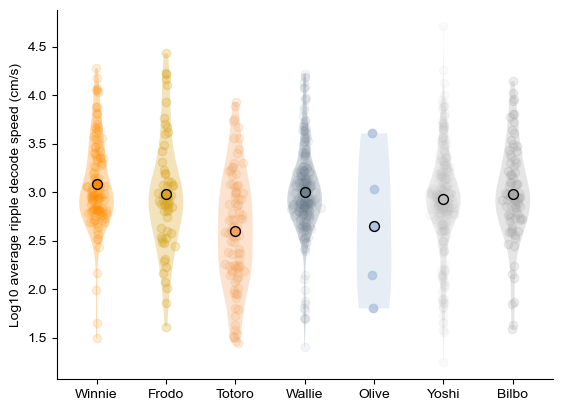

In [ ]:
from ms_stim_analysis.Analysis.utils import violin_scatter

fig = plt.figure()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["svg.fonttype"] = "none"
fig.gca().spines[["top", "right"]].set_visible(False)

labels = []
for i, animal in enumerate(results):
    val = np.log10(results[animal])
    # val = np.array(results[animal])
    val = val[np.isfinite(val)]

    violin_scatter(
        # np.log10(results[animal]),
        # results[animal],
        val,
        color=animal_style.loc[animal, "color"],
        # label=animal,
        # alpha=0.5,
        # width=0.5,
        pos=[i],
        mark_mean=True,
    )
    plt.scatter(
        [i],
        np.mean(val),
        color=animal_style.loc[animal, "color"],
        marker="o",
        s=50,
        edgecolor="black",
    )
    labels.append(animal)

plt.xticks(range(len(results)), labels, rotation=0)
plt.ylabel("Log10 average ripple decode speed (cm/s)")

plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_5/Fig_5d_replay_decode_speed.svg")

In [ ]:
import statsmodels.api as sms
import pandas as pd


model_df = []
for i, animal in enumerate(results.keys()):
    # for opto_interval in ["control", "test"]:

    speeds = results[animal]
    for speed in speeds:
        if np.isnan(speed):
            continue
        model_df.append(
            {
                "Animal": animal,
                # "Interval": opto_interval,
                "Treatment": (
                    "transfected"
                    if animal_style.loc[animal, "background"] == "indianred"
                    else "control"
                ),
                "Rate": speed,
            }
        )
model_df = pd.DataFrame(model_df)
from statsmodels.formula.api import mixedlm

# Convert the 'Treatment' column to a categorical variable
model_df["Treatment"] = model_df["Treatment"].astype("category")
# model_df["Interval"] = model_df["Interval"].astype("category")

# Fit the mixed-effects model
model = mixedlm("Rate ~ Treatment ", model_df, groups=model_df["Animal"])
result = model.fit()

# Print the summary of the model
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Rate        
No. Observations:       968          Method:                  REML        
No. Groups:             7            Scale:                   9101991.9289
Min. group size:        23           Log-Likelihood:          -9120.2627  
Max. group size:        304          Converged:               Yes         
Mean group size:        138.3                                             
--------------------------------------------------------------------------
                           Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------
Intercept                  1404.136  340.292 4.126 0.000  737.176 2071.096
Treatment[T.transfected]    450.035  516.605 0.871 0.384 -562.491 1462.562
Group Var                341866.609  107.746                              

